# Import packages 

In [23]:
# !pip install scikit_posthocs

In [3]:
import pandas as pd
from scipy import stats
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.stats.multicomp as multi
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
import scikit_posthocs as sp

# Run the data cleaning and functions notebook 

In [4]:
%run 02_User_Defined_Functions.ipynb

# Remove extreme outliers

In [5]:
# Call the function that calculates each school's average retention rate
df_cleaned = calculate_school_retention_percentage(df_cleaned)

# Call function to remove extreme outliers before any statistical analysis

df_cleaned = remove_outliers(df_cleaned)

# Student-teacher ratio 

#STU_TEA_RATIO = Student-teacher ratio of the school

In [6]:
df_cleaned_stratio = df_cleaned.dropna(subset=['STU_TEA_RATIO', 'RETENTION_PERCENTAGE'])

# Set up data for x and y axis
x = df_cleaned_stratio['STU_TEA_RATIO']  
y = df_cleaned_stratio['RETENTION_PERCENTAGE']  # Calculated from an earlier step


#  Perform regression 
slope, intercept, r, p, std_err = stats.linregress(x, y)

(slope, intercept, r**2, p, std_err) # r square is the effect size. 

(-0.00559475162316795,
 5.549442297472561,
 3.4746921495783436e-05,
 0.23473899021631553,
 0.004708367041327302)

# Free lunch 

# TOT_FREE_LUNCH = Total number of students eligible for free or reduced-price lunch.

In [7]:
df_cleaned_lunch = df_cleaned.dropna(subset=['TOT_FREE_LUNCH', 'RETENTION_PERCENTAGE'])

x = df_cleaned_lunch['TOT_FREE_LUNCH']  
y = df_cleaned_lunch['RETENTION_PERCENTAGE']   # Calculated from an earlier step

# Perform regression using scipy
slope, intercept, r, p, std_err = stats.linregress(x, y)

(slope, intercept, r**2, p, std_err) # r square is the effect size. 

(-0.00201177133474016,
 6.102234271761522,
 0.0053858504520533906,
 1.1997705709675905e-49,
 0.00013562320369401752)

# Title I status 

#STITLEI = Whether the school is a title 1 school or not

## Step 1: Prepare data for title 1 and non-title 1 schools

In [8]:
print (df_cleaned ['STITLEI'].unique ())

df_cleaned_title = df_cleaned.dropna(subset=['STITLEI', 'RETENTION_PERCENTAGE'])

# Split into Title I and non-Title I schools. 
df_title_yes = df_cleaned_title[df_cleaned_title['STITLEI'] == '1-Yes']
df_title_no = df_cleaned_title[df_cleaned_title['STITLEI'] == '2-No']

# Calculate average percent retention for Title I and non-Title I schools
avg_percent_ret_title_yes = df_title_yes['RETENTION_PERCENTAGE'].mean() 
avg_percent_ret_title_no = df_title_no['RETENTION_PERCENTAGE'].mean() 

print ("Average percent retention for title I schools: ", avg_percent_ret_title_yes)
print ("Average percent retention for non-title I schools: ", avg_percent_ret_title_no)

['1-Yes' '2-No' 'N' 'M']
Average percent retention for title I schools:  5.8929147039428385
Average percent retention for non-title I schools:  4.402544242369076


## Step 2: Check assumption_normal distribution 

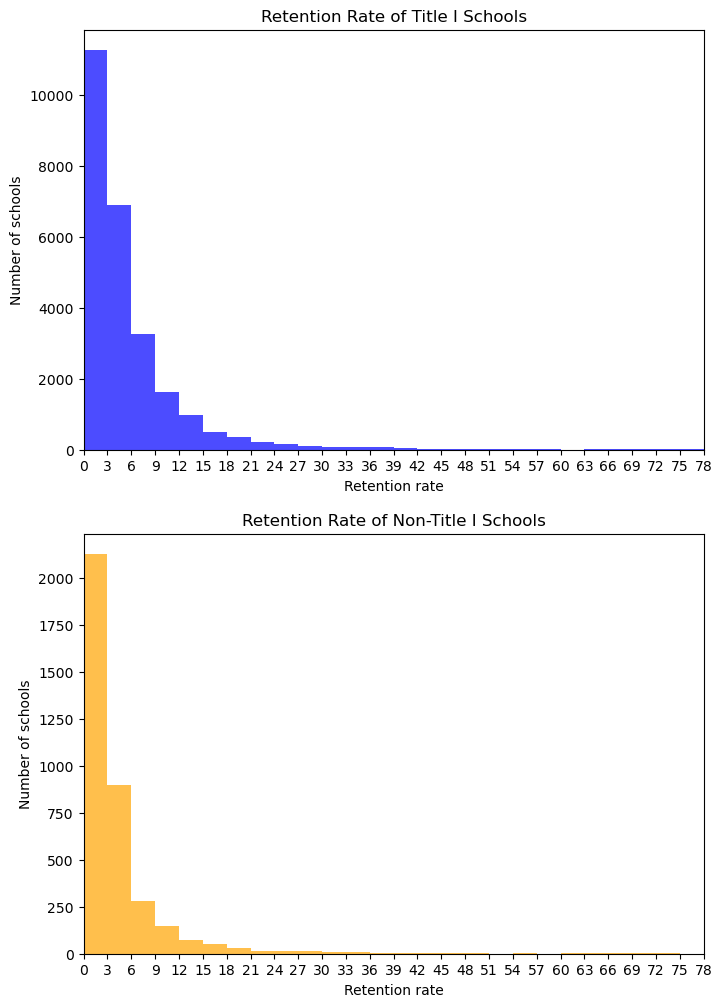

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 12))

bins = np.arange(0, 80, 3)
min_bin = bins.min()
max_bin = bins.max()

# Plot for Title I schools
ax1.hist(df_title_yes['RETENTION_PERCENTAGE'], bins=bins, color='blue', alpha=0.7)
ax1.set_title('Retention Rate of Title I Schools')
ax1.set_xlabel('Retention rate')
ax1.set_ylabel('Number of schools')
ax1.set_xticks(bins)  # Set x-ticks to be at the bins
ax1.set_xlim(min_bin, max_bin)

# Plot for non-Title I schools
ax2.hist(df_title_no['RETENTION_PERCENTAGE'], bins=bins, color='orange', alpha=0.7)
ax2.set_title('Retention Rate of Non-Title I Schools')
ax2.set_xlabel('Retention rate')
ax2.set_ylabel('Number of schools')
ax2.set_xticks(bins)  # Set x-ticks to be at the bins
ax2.set_xlim(min_bin, max_bin)

plt.show()


--> We don't have normal distribution.

## Step 2: Check assumption_equal variance

In [10]:
stat, p = stats.levene(df_title_yes['RETENTION_PERCENTAGE'], df_title_no['RETENTION_PERCENTAGE'])
print('Levene’s test statistic:', stat)
print('p-value:', p)

Levene’s test statistic: 64.7893303847628
p-value: 8.645320307132818e-16


## Step 3: Perform Mann-Whitney U test  (not t-test)

Because we don't have normal distribution, it is better to run U test, the non-parametric version of t-test.

In [11]:
stat, p = mannwhitneyu(df_title_yes['RETENTION_PERCENTAGE'], df_title_no['RETENTION_PERCENTAGE'])

print(f"U statistic: {stat}")
print(f"P-value: {p}")

U statistic: 56800719.5
P-value: 9.030546890174635e-77


--> Title 1 and non-title 1 schools differ significantly in their retention rates.

# School level (Elementary, Middle, High ) 

## Step 1: Prepare data for the three groups

In [12]:
df_cleaned_level = df_cleaned.dropna(subset=['SCHOOL_LEVEL','RETENTION_PERCENTAGE'])

# Split data into elementary, middle, and high schools
df_elementary = df_cleaned_level[df_cleaned_level['SCHOOL_LEVEL'] == 'Elementary']
df_middle = df_cleaned_level[df_cleaned_level['SCHOOL_LEVEL'] == 'Middle']
df_high = df_cleaned_level[df_cleaned_level['SCHOOL_LEVEL'] == 'High']

# Calculate average percent retention for each school level 
school_levels_dic = {
    'Elementary': df_elementary,
    'Middle': df_middle,
    'High': df_high
}

# Print mean scores just to confirm 
for level, df in school_levels_dic.items(): 
    avg_percent_ret = df['RETENTION_PERCENTAGE'].mean()
    print(f"Average percent retention for {level.lower()} schools: {avg_percent_ret}") # lower case 


Average percent retention for elementary schools: 4.434302362728578
Average percent retention for middle schools: 2.3021762137086195
Average percent retention for high schools: 9.628361530439802


##  Step 2: Check assumption_normal distribution

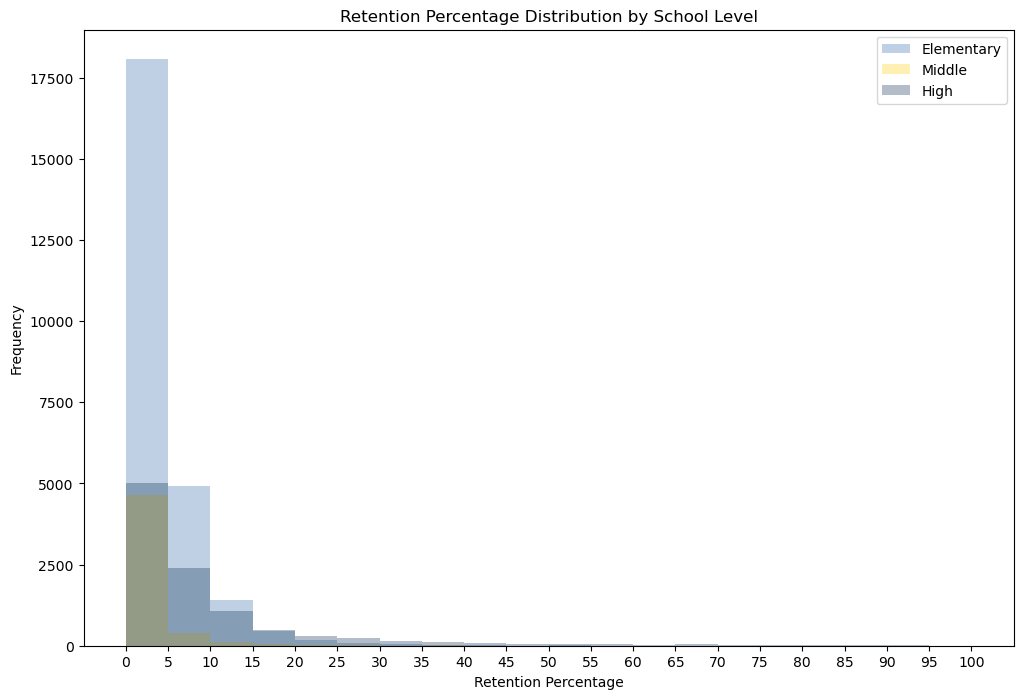

In [13]:
# Set x axis value ranges with 5 intervals 
bins = list(range(0, 101, 5))  

def plot_histograms (school_levels_dic, bins):
    plt.figure(figsize=(12, 8))
    for level, df in school_levels_dic.items():
        plt.hist(df['RETENTION_PERCENTAGE'], bins=bins, alpha=0.3, label=level)
    plt.title('Retention Percentage Distribution by School Level')
    plt.xlabel('Retention Percentage')
    plt.ylabel('Frequency')
    plt.legend()
    plt.xticks(bins)
    plt.show()

# Plot histograms for each school level with custom bins
plot_histograms(school_levels_dic, bins)

--> Data is not really normally distributed. 

## Step 2: Check assumption_ equal variance 

In [14]:
stat, p = stats.levene(
    df_elementary['RETENTION_PERCENTAGE'],
    df_middle['RETENTION_PERCENTAGE'],
    df_high['RETENTION_PERCENTAGE']
    )

print('Levene’s test statistic:', stat)
print('Levene’s test p-value:', p)

Levene’s test statistic: 1762.6208383576268
Levene’s test p-value: 0.0


-> P<.05. Do not have equal variances.

## Step 3: Conduct Kruskal-Wallis H Test 

Because we don't have normal distribution or equal variance, run Krusaka Wallis H test (non-parametric version of ANOVA). 

In [15]:
stat, p = kruskal(
    df_elementary['RETENTION_PERCENTAGE'],
    df_middle['RETENTION_PERCENTAGE'],
    df_high['RETENTION_PERCENTAGE']
    )

print(f"Kruskal-Wallis H Test statistic: {stat}")
print(f"P-value: {p}")

Kruskal-Wallis H Test statistic: 5613.090711674902
P-value: 0.0


### Conduct post hoc Dunn's test: compare MEDIAN 

In [16]:
# Get the median score of the three groups
median_percent_ret_elementary = df_elementary['RETENTION_PERCENTAGE'].median()
median_percent_ret_middle = df_middle['RETENTION_PERCENTAGE'].median()
median_percent_ret_high = df_high['RETENTION_PERCENTAGE'].median()

print(f"Median for elementary schools: {median_percent_ret_elementary}")
print(f"Median for middle schools: {median_percent_ret_middle}")
print(f"Median for high schools: {median_percent_ret_high}")


Median for elementary schools: 2.941176470588235
Median for middle schools: 1.0638297872340425
Median for high schools: 5.08130081300813


In [17]:
# Conduct Dunn's test 
data = [
    df_elementary['RETENTION_PERCENTAGE'],
    df_middle['RETENTION_PERCENTAGE'],
    df_high['RETENTION_PERCENTAGE']
    ]

p_values = sp.posthoc_dunn(data, p_adjust='bonferroni')

print(p_values)

               1    2              3
1   1.000000e+00  0.0  2.650989e-309
2   0.000000e+00  1.0   0.000000e+00
3  2.650989e-309  0.0   1.000000e+00


-> Elementary, middle, and high schools differ significantly from each other in their median retention rate (p<.05)

# Locale category (city, suburban, rural, etc.) 

## Step 1: Prepare 4 dataframes 

In [18]:
df_cleaned_local = df_cleaned.dropna(subset=['LOCAL_CATEGORY', 'RETENTION_PERCENTAGE'])

# Split the dataframe into rural, town, suburb, and city schools
df_city= df_cleaned_local[df_cleaned_local['LOCAL_CATEGORY'] == 'City']
df_rural = df_cleaned_local[df_cleaned_local['LOCAL_CATEGORY'] == 'Rural']
df_suburb= df_cleaned_local[df_cleaned_local['LOCAL_CATEGORY'] == 'Suburb']
df_town = df_cleaned_local[df_cleaned_local['LOCAL_CATEGORY'] == 'Town']

# Calculate average percent retention for each school level.
local_dic = {
    'City': df_city,
    'Rural': df_rural, 
    'Suburb': df_suburb,
    'Town': df_town
    }

# Loop through each item in the dic and get aveg ret rate  (just to confirm)
for local, df in local_dic.items(): 
    avg_percent_ret = df['RETENTION_PERCENTAGE'].mean()
    print(f"Average percent retention for {local.lower()} schools: {avg_percent_ret}") # lower case 

Average percent retention for city schools: 6.054132457970138
Average percent retention for rural schools: 5.977649119364936
Average percent retention for suburb schools: 4.517558527276483
Average percent retention for town schools: 5.467555355831212


## Step 2: Check assumption_equal variance

In [19]:
stat, p = stats.levene(
    df_city['RETENTION_PERCENTAGE'], 
    df_rural['RETENTION_PERCENTAGE'], 
    df_suburb['RETENTION_PERCENTAGE'],
    df_town['RETENTION_PERCENTAGE']
    )

print('Levene’s test statistic:', stat)
print('Levene’s test p-value:', p)

Levene’s test statistic: 56.474148431691546
Levene’s test p-value: 2.0180982659700348e-36


## Step 2: Conduct Kruskal-Wallis H Test 

Since we don't have equal variance, run H test rather than ANOVA.

In [20]:
stat, p = kruskal(
    df_city['RETENTION_PERCENTAGE'],
    df_town['RETENTION_PERCENTAGE'],
    df_suburb['RETENTION_PERCENTAGE'],
    df_rural['RETENTION_PERCENTAGE']
    )

print(f"Kruskal-Wallis H Test statistic: {stat}")
print(f"P-value: {p}")

Kruskal-Wallis H Test statistic: 1460.4571476857832
P-value: 0.0


### Conduct post hoc Dunn's test: compare MEDIAN 

Since they differ significantly, we do follow-up analysis to see which groups differ.

In [21]:
# Get the median score of the four groups
median_percent_ret_city = df_city['RETENTION_PERCENTAGE'].median()
median_percent_ret_rural = df_rural['RETENTION_PERCENTAGE'].median()
median_percent_ret_suburb = df_suburb['RETENTION_PERCENTAGE'].median()
median_percent_ret_town = df_town['RETENTION_PERCENTAGE'].median()

print(f"Median for city schools: {median_percent_ret_city}")
print(f"Median for rural schools: {median_percent_ret_rural}")
print(f"Median for suburb schools: {median_percent_ret_suburb}")
print(f"Median for town schools: {median_percent_ret_town}")


Median for city schools: 2.7777777777777777
Median for rural schools: 4.166666666666666
Median for suburb schools: 2.312138728323699
Median for town schools: 3.198837209302326


In [22]:
# Conduct Dunn's test
data = [
    df_city['RETENTION_PERCENTAGE'],
    df_rural['RETENTION_PERCENTAGE'],
    df_suburb['RETENTION_PERCENTAGE'],
    df_town['RETENTION_PERCENTAGE']
    ]
p_values = sp.posthoc_dunn(data, p_adjust='bonferroni')

print(p_values)

              1             2             3             4
1  1.000000e+00  4.239812e-98  1.183132e-53  1.850767e-04
2  4.239812e-98  1.000000e+00  0.000000e+00  9.028447e-38
3  1.183132e-53  0.000000e+00  1.000000e+00  7.702821e-63
4  1.850767e-04  9.028447e-38  7.702821e-63  1.000000e+00


--> All pairs differ significantly.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=edfebf59-8cf0-4b7e-b1cf-d80b21ef0191' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>